## Declare All Variables

In [1]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000
num_epochs = 30

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Download and Setup Data

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

--2022-06-27 04:23:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.09s   

2022-06-27 04:23:53 (58.0 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [3]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

## Tokenizer

In [4]:
# Tokenize word
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index


## Sequence, padding, and Truncating (Preprocessing Data)

In [5]:
# Sequence
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

# Padding and Truncating
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulaty size = {vocabSize}")

Vocabulaty size = 25638


## Create Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, GlobalAveragePooling1D

# Built nn architecture
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Print Model Summary
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_8 (Dense)             (None, 24)                408       
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


## Compile Model

In [14]:
# Compile model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

## Turn List into Array

In [15]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## Fit Array

In [16]:
# Fit model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 4s - loss: 0.6708 - accuracy: 0.5730 - val_loss: 0.6007 - val_accuracy: 0.6496 - 4s/epoch - 6ms/step
Epoch 2/30
625/625 - 4s - loss: 0.4401 - accuracy: 0.8247 - val_loss: 0.3863 - val_accuracy: 0.8402 - 4s/epoch - 6ms/step
Epoch 3/30
625/625 - 3s - loss: 0.3136 - accuracy: 0.8764 - val_loss: 0.3573 - val_accuracy: 0.8481 - 3s/epoch - 6ms/step
Epoch 4/30
625/625 - 3s - loss: 0.2621 - accuracy: 0.8977 - val_loss: 0.3509 - val_accuracy: 0.8515 - 3s/epoch - 5ms/step
Epoch 5/30
625/625 - 3s - loss: 0.2268 - accuracy: 0.9114 - val_loss: 0.3434 - val_accuracy: 0.8566 - 3s/epoch - 5ms/step
Epoch 6/30
625/625 - 3s - loss: 0.1996 - accuracy: 0.9225 - val_loss: 0.3501 - val_accuracy: 0.8526 - 3s/epoch - 5ms/step
Epoch 7/30
625/625 - 3s - loss: 0.1774 - accuracy: 0.9334 - val_loss: 0.3661 - val_accuracy: 0.8548 - 3s/epoch - 5ms/step
Epoch 8/30
625/625 - 3s - loss: 0.1592 - accuracy: 0.9409 - val_loss: 0.3759 - val_accuracy: 0.8523 - 3s/epoch - 5ms/step
Epoch 9/30
625/625 - 3s 

## Predict your own sentence

In [17]:
sen = ["You very stuopid"]
seq = tokenizer.texts_to_sequences(sen)
pad = pad_sequences(seq, padding = padding_type, truncating = trunc_type, maxlen = max_length)
print(model.predict(pad))

[[0.05741683]]


## Show Accuracy and Loss

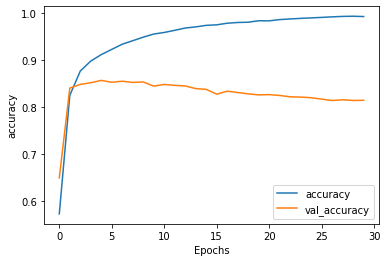

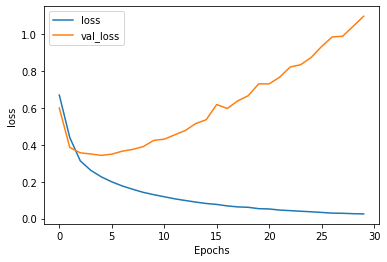

In [18]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Download the Embeddings

In [19]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [20]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [21]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Try Projecting the Embeddings at https://projector.tensorflow.org/